In [1]:
import chirho.observational.handlers
import pyro
import torch
import pyro.distributions as dist
from chirho.interventional.handlers import Interventions, do
from chirho.counterfactual.handlers.counterfactual import TwinWorldCounterfactual
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.indexed.ops import gather, IndexSet
from functools import singledispatch
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal, AutoNormal
from functools import partial
from chirho.indexed.ops import gather, IndexSet
from chirho.observational.handlers import condition
from chirho.observational.handlers.condition import Observations
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, sqrt
from itertools import product
from random import randint
from contextlib import nullcontext
import matplotlib
from utils.build_svi_iter import build_svi_iter
from utils.build_zuko_guide import build_zuko_guide, ZukoGuide
from chirho.observational.handlers.predictive import PredictiveModel
import seaborn as sns
from chirho.robust.ops import influence_fn
# from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator
from chirho.robust.internals.full_linearize_from_left import full_linearize_from_left
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood

tnsr = torch.tensor

# Settings
pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)


# seed = randint(0, int(1e6))
# print(seed)

seed = 955973

pyro.set_rng_seed(seed)

# Simple Model

In [2]:
# Sample from an MVN by sampling two normals sequentially.
class ChainedNormals(torch.nn.Module):
    def __init__(self, loc, cov, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.loc1 = loc[0]
        self.std1 = torch.sqrt(cov[0, 0])
        
        self.loc2_base = loc[1]
        self.sigma_21 = cov[1, 0]
        self.sigma_11 = cov[0, 0]
        self.sigma_22 = cov[1, 1]
        
        # Precompute part of the conditional mean expression
        self.conditional_loc2_base = self.loc2_base - (self.sigma_21 / self.sigma_11) * self.loc1
        self.conditional_std2 = torch.sqrt(self.sigma_22 - (self.sigma_21**2 / self.sigma_11))
    
    def forward(self):
        # Sample from the first normal distribution
        z1 = pyro.sample("z1", dist.Normal(
            loc=self.loc1,
            scale=self.std1
        ))
        
        # Compute the conditional mean using the sampled z1
        conditional_loc2 = self.conditional_loc2_base + (self.sigma_21 / self.sigma_11) * z1
        
        # Sample from the second normal distribution with the conditional mean
        z2 = pyro.sample("z2", dist.Normal(
            loc=conditional_loc2,
            scale=self.conditional_std2
        ))
        
        return z1, z2

In [3]:
prior = ChainedNormals(
    loc=torch.tensor([0., 0.]),
    cov=torch.tensor([
        [5.0, -0.0],
        [-0.0, 5.0]
    ])
)

Text(0.5, 0.98, 'Prior Samples')

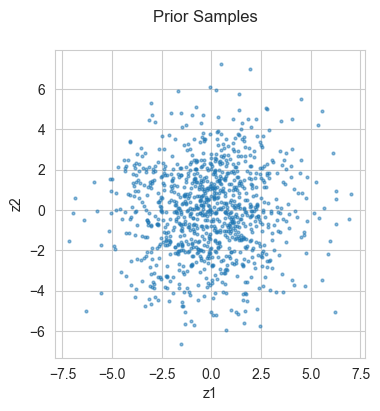

In [4]:
# Visualize samples from the prior.
with pyro.plate("prior_viz", 1000):
    prior_samples = prior()

plt.figure(figsize=(4, 4))
plt.scatter(prior_samples[0].detach().numpy(), prior_samples[1].detach().numpy(), alpha=0.5, s=4.)
plt.xlabel("z1")
plt.ylabel("z2")
plt.suptitle("Prior Samples")

In [5]:
class FullModel(torch.nn.Module):
    def __init__(self, prior: torch.nn.Module, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.prior = prior
        self.noise = torch.tensor(0.5)
        
    def forward(self, n=1):
        ps = self.prior()  # prior sample
        
        # TODO make the normal prior just use a dict and not a tuple.
        #  The issue is that the tuple return makes it hard to use a
        #  guide in place of the prior, which returns a dict by default.
        if isinstance(ps, dict):
            z1, z2 = ps["z1"], ps["z2"]
        elif isinstance(ps, tuple):
            z1, z2 = ps
        else:
            raise NotImplementedError(f"Unknown prior sample type: {type(ps)}")
        
        with pyro.plate("data", n, dim=-1):
            x = pyro.sample("x", dist.Normal(z1 + z2, self.noise))
    
        return x
model = FullModel(prior)

# Data Generation

In [6]:
true_latents = dict(
    z1=tnsr([1.]),
    z2=tnsr([-3.])
)

In [7]:
N = 100
observed_data = dict(x=condition(partial(model, n=N), data=true_latents)())

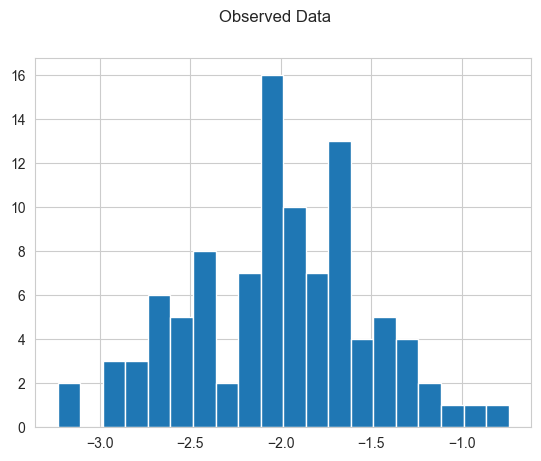

In [8]:
plt.hist(observed_data["x"].detach().numpy(), bins=20)
plt.suptitle("Observed Data")
pass

In [9]:
conditioned_model = condition(partial(model, n=N), data=observed_data)

# Inference

In [10]:
# # DEBUG
# class ManualGuide(torch.nn.Module):
#     def __init__(self, *args, **kwargs):
#         

In [11]:
svi = build_svi_iter(
    model=conditioned_model,
    lr=1e-3,
    # block_latents=["z1", "z2"],
    # variational_family=AutoMultivariateNormal,
    # variational_family=AutoDelta,
    
    variational_family=ZukoGuide,
    features=2,
    context=0,
    transforms=1,
    hidden_features=(8, 8)
)

In [12]:
NITER = 5000
for _ in range(NITER):
    print(f"Progress {_}/{NITER}", end="\r")
    svi.svi_iter()

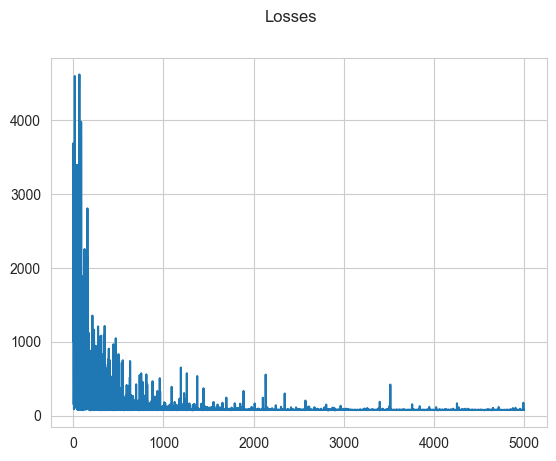

In [13]:
plt.plot(svi.losses)
plt.suptitle("Losses")
pass

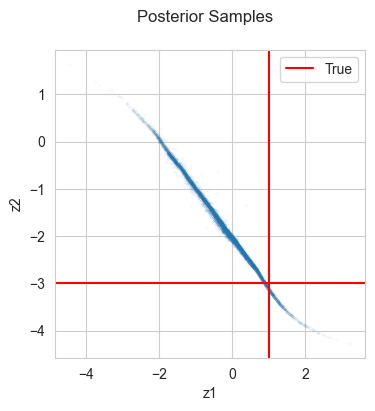

In [14]:
# Plot posterior samples.
with pyro.plate("posterior_viz", 1e4):
    posterior_samples = svi.guide()
    
plt.figure(figsize=(4, 4))
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=1.0, s=0.001)
plt.axvline(true_latents["z1"].item(), color="red", label="True")
plt.axhline(true_latents["z2"].item(), color="red")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.suptitle("Posterior Samples")
pass

# Functional

In [15]:
class IntervenedSum(torch.nn.Module):
    
    def __init__(self, model, z2value, num_monte_carlo, reshaper=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        self.z2value = z2value
        self.num_monte_carlo = num_monte_carlo
        self.reshaper = reshaper or (lambda x: x)
        
    def forward(self, *args, **kwargs):
        with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
            with do(actions=dict(z2=self.z2value)):
                x = self.model(*args, **kwargs)
                return self.reshaper(x)

In [16]:
functional = IntervenedSum(model, z2value=tnsr([0.]), num_monte_carlo=1000, reshaper=torch.mean)

In [17]:
# Failure to capture the true answer due to non-identification (true answer is 1.).
functional()

tensor(0.0817)

# Posterior Sensitivity

In [18]:
# Generate a grid of z1, z2 value pairs to assess sensitivity wrt.
GRID_RES = 300
z1_values = torch.linspace(-5., 5., GRID_RES)
z2_values = torch.linspace(-5., 5., GRID_RES)
z1_grid, z2_grid = torch.meshgrid(z1_values, z2_values, indexing='ij')

# And flatten into something we can pass to the influence function computation.
points = dict(z1=z1_grid.reshape(-1), z2=z2_grid.reshape(-1))

In [19]:
# Now, we encounter some complexity. The functional needs to be taken with respect to the guide, not the model, as that is what our log probabilities will be taken with respect to as well.

# So the parameter path of the guide module (to the log_prob_params) needs to match the parameter path of the func_target_params, which is now mediated through the PredictiveModel.
# So...

In [20]:
class IntervenedSum_FunctionalOfGuide(IntervenedSum):
    def __init__(self, guide, model, *args, **kwargs):
        super().__init__(PredictiveModel(model, guide), *args, **kwargs)

In [21]:
partial_funcofguide = partial(
    IntervenedSum_FunctionalOfGuide,
    model=model,
    z2value=tnsr([0.]),
    num_monte_carlo=1000,
    reshaper=torch.mean
)

In [22]:
partial_funcofguide(svi.guide)()

tensor(-0.2970, grad_fn=<MeanBackward0>)

In [23]:
# HACK for now, because I couldn't figure out how to reliably get log probabilities out of an auto-guide or zuko guide.
class ManualLogProbComputer(torch.nn.Module):
    def __init__(self, guide):
        super().__init__()
        self.guide = guide
        
    def forward(self, points):
        stacked_points = torch.hstack((points["z1"][:, None], points["z2"][:, None]))
        posterior_dist = self.guide.get_posterior()
        return posterior_dist.log_prob(stacked_points)

In [24]:
with torch.no_grad():
    compute_prior_inf_on_prior_pred = full_linearize_from_left(
        svi.guide,
        functional=partial_funcofguide,
        num_samples_outer=int(1e3),  # number of samples used to estimate empirical fisher.
        num_samples_inner=1,  # not used for this b/c no marginalization required.
        points_omit_latent_sites=False,  # no marginalization of latents is required.
        # The parameter paths in the svi.guide module and functional differ, despite
        #  pointing to the same parameters. This option will try to remap matching
        #  parameters to have the same path.
        remap_parameter_paths=True,
        log_prob_computer=ManualLogProbComputer,
        predictive_sites=("z1", "z2")
    )

In [25]:
compute_prior_inf_on_prior_pred.__closure__[-1].cell_contents.keys()

dict_keys(['z1', 'z2'])

In [29]:
import time
few_points = {k: v for k, v in points.items()}
with torch.no_grad():
    s = time.time()
    prior_inf_on_prior_pred = compute_prior_inf_on_prior_pred(few_points)
    print("Elapsed:", time.time() - s)

Elapsed: 0.8038439750671387


In [ ]:
# DEBUG below here.

In [ ]:
guide_wo_aux = AuxiliarySiteBlocker(svi.guide)
with pyro.poutine.trace() as tr:
    guide_wo_aux()
    # svi.guide()

In [ ]:
trace = tr.get_trace()

In [ ]:
trace.nodes

In [ ]:
from chirho.robust.internals.full_linearize_from_left import ExactLogProb

with pyro.poutine.block(hide=["z1", "z2"]):
    # elp = ExactLogProb(svi.guide)(points)
    elp = ExactLogProb(guide_wo_aux)(points)

In [ ]:
elp.max()

In [ ]:
class CustomLogProbComputer(torch.nn.Module):
    def __init__(self, guide):
        super().__init__()
        self.guide = guide
        
    def forward(self, points):
        stacked_points = torch.hstack((points["z1"][:, None], points["z2"][:, None]))
        posterior_dist = self.guide.get_posterior()
        return posterior_dist.log_prob(stacked_points)

In [ ]:
svi.guide.flow().log_prob(torch.hstack((points["z1"][:, None], points["z2"][:, None])))

In [ ]:
svi.guide.get_posterior().log_prob(
    torch.hstack((z1_grid.reshape(-1)[:, None], z2_grid.reshape(-1)[:, None]))
)

In [ ]:
CustomLogProbComputer(svi.guide)(points)

In [ ]:
from chirho.robust.internals.utils import make_functional_call
params_test, func_test = make_functional_call(CustomLogProbComputer(svi.guide))
params_test

In [ ]:
func_test(params_test, points)

In [ ]:
with pyro.poutine.trace() as tr:
    AutoDelta(model)()
tr.get_trace().nodes

In [ ]:
ExactLogProb(PredictiveModel(prior, svi.guide))(points)

In [ ]:
BatchedNMCLogMarginalLikelihood(model, svi.guide)(dict(
    x=torch.randn(100, 1)
))

In [ ]:
BatchedNMCLogMarginalLikelihood(prior, svi.guide)(dict(
    x=torch.randn(1000, 1)
))

In [ ]:
class TrivariateGaussian(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Parameters of different shapes.
        self.loc_ab = torch.nn.Parameter(torch.tensor([0., 1.0]))
        self.loc_c = torch.nn.Parameter(torch.tensor([2.0]))

    def forward(self):
        ab = pyro.sample("ab", dist.Normal(self.loc_ab, 1.0).to_event(1))
        c = pyro.sample("c", dist.Normal(self.loc_c, 1.0).to_event(1))

        return dict(
            ab=ab,
            c=c,
        )


In [ ]:
data = pyro.infer.Predictive(TrivariateGaussian, num_samples=11)()
ExactLogProb(PredictiveModel(TrivariateGaussian(), TrivariateGaussian()))(data)

In [ ]:
BatchedNMCLogMarginalLikelihood(PredictiveModel(TrivariateGaussian(), TrivariateGaussian()))(data)